# Compute degrees of belief with Multi-Layer Belief Model in python

Welcome to this Jupyter Notebook, where we present an implementation of the Multi-Layer Belief model as defined in the paper titled "A Belief Model for Conflicting and Uncertain Evidence: Connecting Dempster-Shafer Theory and the Topology of Evidence" by Daira Pinto Prieto, Ronald de Haan, and Aybüke Özgün. You can find it at [this link](https://doi.org/10.24963/kr.2023/54).

The primary goal of this notebook is to offer data researchers an accessible way to explore the potential benefits of this theoretical model for their experiments, using a simple toy example. Please note that this research is a work in progress, and we have not yet developed an optimized implementation. 

Consider using this model if:

1) Your data are independent pieces of evidence that can be model by sets. 
2) Each piece of evidence has a degree of certainty between 0 and 1.
3) You want to combine these pieces of evidence to derive a degree of belief.

One key distinction of this approach is that the user can set specific parameters to establish boundaries within the evidence that will shape the belief of the agent. That means, this model is flexible enough to compute beliefs according to various standards that represent agents’ evidential demands. These standards are determined by the intrinsic properties of the evidence, rather than thresholds chosen by an expert agent.  In addition, well-established approaches such as Dempster-Shafer Theory or Topological Models of Evidence can also be replicated by configuring these parameters in a specific manner.  

We encourage you to try it out and share your results and feedback with us! If you have any questions or need assistance, please don't hesitate to reach out to us at d.pintoprieto@uva.nl.

<sub> Credits: We'd like to acknowledge Arthur Boixel for his contributions to the coding structure and implementation of this notebook. </sub>

## What to expect as you scroll

First, let's familiarize ourselves with the vocabulary and the main objectives of this model. From a general point of view, the aim of the model is to compute *degrees of belief* based on provided *evidence*. This evidence is the input to the model and comprises three key elements:

- A *total set* $S$: This set is the collection of all the possible states. Consequently, our evidence consists of subsets of this set, and we can compute the degree of belief for any subset within this set.
- Set of *pieces of evidence* $E$: Each piece of evidence is represented as a subset of $S$. When we have multiple pieces of evidence that we wish to consider collectively, we have a collection of subsets of $S$. 
- *Degree of certainty* assigned to each piece of evidence: This model is designed to combine uncertain evidence, and this uncertainty is quantified by a degree from 0 to 1 associated with each piece of evidence.

To illustrate, consider the following scenario: Imagine we are trying to determine the color of a picture. We define the total set as: 

$$ S = \{\text{white}, \text{yellow}, \text{red}, \text{blue}, \text{black}\} $$

We receive the following evidence:

- The first sensor asserts that the picture is in black and white with $66\%$ certainty.
- The second sensor claims that the picture is not blue with $70\%$ certainty.
- The third sensor states that the picture is in black and blue with $81\%$ certainty. 

In this case, our input evidence set would appear as follows:

$$ E = \{(\{\text{white},\text{black}\}, 0.66), (\{\text{white}, \text{black}, \text{red}, \text{yellow}\},0.70), (\{\text{black}, \text{blue}\},0.81)\}. $$ 

Now, before going through the details of the model, remember our primary objective: we aim to combine this evidence, taking into account both its qualitative aspects (such as possible contradictions or support) and its quantitative attributes (acknowledging that not all evidence carries the same level of certainty). Subsequently, we want to compute degrees of belief for propositions like "The picture is blue" (represented by the set $\{\text{blue}\}$), "The picture is red, yellow, or blue" (represented by the set $\{\text{red}, \text{yellow}, \text{blue}\}$), and so on.

The remainder of this document is structured as follows:

<b>1- Packages and auxiliary functions.</b> This section can be skipped by those who want to focus on the core concepts.

<b>2 - Topology class and related functions.</b> This model offers increased expressive power compared to other mathematical belief models due to its integration with Topological Models of Evidence—a logical approach for combining evidence. In this section, you'll find a brief introduction to key topological concepts. While a `Topology class` is defined here, users can skip this technical part. The section also includes examples and visual aids to enhance understanding of the topological concepts.

<b>3 - Multi Layer Belief Model class.</b> In this section, we introduce our multi-layer belief model. We'll explain how the model operates and the various parameters you can configure. A `Model class` is defined, which contains all the necessary methods for calculating the degree of belief for a proposition denoted as $P$ using the multi-layer belief model. You'll also find some examples and a visualization illustrating one of the intermediate results of the model. 

<b>4 - Paper example.</b> The last section presents a full version of the example shown in the paper. 


## 1 - Importing necessary packages and definition of auxiliary functions.

In [33]:
import sys
import ast
from functools import reduce
from itertools import chain, combinations 

# Packages for plots
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math

# Pacakge for display tables
from tabulate import tabulate

This two auxiliary functions will help us to work with sets and dictionaries. Each set can be uniquely identified by a string, and thus used as a dictionary key.

In [34]:
def get_key(s):
    """
    This method gives a unique string identifier to a set.

    Args:
        s (set): Set.
        
    Returns:
        k (string): Unique string identifier for s.
    """
    elements = list(s)
    elements.sort()  # Sort the elements to maintain order
    return "{" + ", ".join("'" + element + "'" for element in elements) + "}"


def get_set(k):
    """
    This method retrieves a set from a unique string identifier.

    Args:
        k (string): Unique string identifier.
        
    Returns:
        s (set): Corresponding set.
    """
    elements = ast.literal_eval(k)
    return set(elements)

# Example usage
s = {'b', 'a'}
k = get_key(s)
# print(type(k))
# print(k)
s1 = get_set(k)
# print(s1)
# print(s == s1)

## 2 - Topology class and related functions


Let's revisit the example involving images and colors. Consider the total set:

$$ S = \{\text{white}, \text{yellow}, \text{red}, \text{blue}, \text{black}\} $$

In this representation, we'll use abbreviations for the colors: $w$ for white, $y$ for yellow, $r$ for red, $b$ for blue, and $bk$ for black. Now, let's focus on the set of pieces of evidence. The set of evidence to use the multi-layer belief model would be something like:

$$ E = \big\{(\{w, bk\}, 0.66), (\{w, bk, r, y\}, 0.70), (\{bk, b\}, 0.81)\big\}. $$

However, for studing the topological aspects of the evidence, we only need its qualitative part. So let's consider this set of evidence instead:

$$ E = \big\{\{w, bk\}, \{w, bk, r, y\}, \{bk, b\}\big\}. $$

We'll refer to this set as the *subbasis of the evidence*. From this subbasis, we can derive the *basis of the evidence* by constructing a set that includes all elements closed under finite intersections. Finally, the *topology generated by the evidence* is the set containing all elements of the basis and which is closed under arbitrary unions.

Within this topology, our specific focus is on identifying elements known as *dense elements* of the topology. An element $T$ in the topology $\tau$ is considered *dense* if its intersection with every other element of the topology (excluding the empty set) is non-empty.

The Topology class presented in this section performs calculations involving the subbasis, basis, topology, and the subset of dense sets from a given set of pieces of evidence $E$. Additionally, we define a function that determines the dense set with the smallest size within a topology generated by a set of evidence $E$.

Towards the end of this section, you'll find practical examples illustrating these concepts and a visual representation that will help you understand the number of dense elements present in the topology generated by your data. In the following section, we'll explain how these topological concepts will be employed to combine evidence and calculate degrees of belief.

<sub><b> Warning: </b> This code is not optimized. We compute and traverse the power set of the set of evidence. The intention of this implementation is to assist you in comprehending the model by experimenting with small examples.</sub>

In [35]:
class Topology:
    
    """ This class defines an object Topology """
    
   
    def __init__(self, E, S = None):
        """
        This is the constructor for Topology.

        Args:
            E (list/dictionary): List of pieces of evidence / Dictionary with pieces of evidence as keys and certainty degree as values.
            S (set, optional): Total set. 

        Returns:
            None
        """

        if E is None:
            raise ValueError("E (Evidence) argument must be provided.")

        if isinstance(E, dict):
            E = [get_set(k) for k in E.keys()]

        if S is None:
            S = set().union(*E)

        self.S = S
        self.E = E
    
    
    def get_subbasis(self):
        """
        This methods returns the subbasis of the topology generated by a collection of pieces of evidence. This is exactly the list of pieces of evidence. 

        Returns:
            E (list):   Evidence
        """
        
        return self.E
    
    def get_basis(self):
        """
        This method computes the basis of the topology generated by the evidence. Namely, the closure by finite intersections of the subbais.
        
        Returns:
            basis (list) : The basis of the topology.
        """
        
        basis = self.get_subbasis() # list of sets
        updated = True

        while updated:
            updated = False  # Set to False initially

        for (s1, s2) in combinations(basis, 2):
            inter = s1.intersection(s2)
            if inter not in basis:
                basis.append(inter)
                updated = True

        return basis

    def get_topology(self):
        """
        This methods returns the topology generated by the evidence. Namely, the closure by finite intersections and unions of the basis, plus the empty set and the total set.

        Returns:
            topology (list) : The topology.
        """

        basis = self.get_basis()
        topology = basis  # Initialize the topology with the basis elements

        # Add the empty set
        if set() not in topology:
            topology.append(set())

        # Add the total set
        if self.S not in topology:
            topology.append(self.S) 
        
        updated = True

        while updated:
            updated = False

            for size in range(2, len(basis) + 1):
                combinations_size = combinations(basis, size) # Generate all combinations of size 'size' from the basis elements

                for combination in combinations_size:
                    union = set().union(*combination)  # Compute the union of the combination elements
                    if union not in topology:
                        topology.append(union)  # Add the union to the topology
                        updated = True

        return topology

    def get_dense_sets(self):
        """
        This method computes the set of dense elements of the topology. 
        A set T is dense in the topology if (i) it belongs to the topology 
        and (ii) has a non-empty intersection with every non-empty set in the topology.

        Returns:
            dense_sets (list) : The set of dense sets of the topology.
        """
        topology = self.get_topology()
        topology.remove(set())
        dense_sets = []

        for candidate_set in topology:
            is_dense = True

            for other_set in topology:
                if not candidate_set.intersection(other_set): # Check all possible intersections
                    is_dense = False
                    break

            if is_dense:
                dense_sets.append(candidate_set)

        return dense_sets        


    def print(self):
        """
        This methods prints all the methods of the Topology class.

        Returns:
            None
        """

        print("Subbasis: " + str(self.get_subbasis()))
        print("Basis: " + str(self.get_basis()))
        print("Topology: ", str(self.get_topology()))
        print("Dense sets: ", str(self.get_dense_sets()))


In [36]:
def minimal_dense_set(sets):
    """
    This function computes the smallest dense set of a topology generated from a list of sets.
    A set S is dense if (i) it belongs to the topology and (ii) has a non-empty intersection with every set in the topology.

    Args:
        sets (list): A list of pieces of evidence.

    Returns:
        (set): The smallest dense set of the topology.
    """
    topology = Topology(sets)

    dense_sets = topology.get_dense_sets()

    return min(dense_sets, key=len, default=topology.S)

### Examples

Running the following code will provide you with three examples of evidence sets:

- An evidence set $E1$ without contradictions (no empty intersections among the evidence).
- An evidence set $E2$ with some contradictions but the majority of sets in the topology are dense.
- An evidence set $E3$ with some contradictions and a minority of sets in the topology are dense.

A Venn diagram of the evidence will be displayed, allowing you to easily visualize the possible intersections and unions. Additionally, all the methods of the Topology class will be printed for each case. Afterward, you can scroll down to explore our proposed visualization of the amount of dese sets in the computed topologies.

In [37]:
# Input

# Total set of states
S = {'w', 'y', 'r', 'b', 'bk'}

# Non-contradictory set of evidence
E1 = [{'r', 'y', 'w', 'bk'}, {'w', 'bk'}, {'bk', 'b'}] 

# Contradictory but dense set of evidence
E2 = [{'y', 'w'}, {'w', 'r', 'bk'}, {'bk', 'b'}] 

# Contradictory non-dense set of evidence
E3 = [{'w', 'b'}, {'bk', 'b'}, {'b', 'r'}, {'w'}, {'bk'}, {'r'}] 

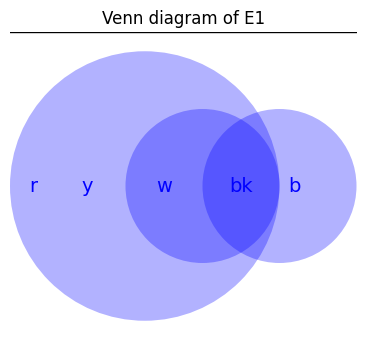

Example with E1 = [{'r', 'y', 'w', 'bk'}, {'w', 'bk'}, {'bk', 'b'}] : 
Subbasis: [{'y', 'w', 'bk', 'r'}, {'bk', 'w'}, {'b', 'bk'}]
Basis: [{'y', 'w', 'bk', 'r'}, {'bk', 'w'}, {'b', 'bk'}, {'bk'}]
Topology:  [{'y', 'w', 'bk', 'r'}, {'bk', 'w'}, {'b', 'bk'}, {'bk'}, set(), {'y', 'r', 'bk', 'w', 'b'}, {'b', 'bk', 'w'}]
Dense sets:  [{'y', 'w', 'bk', 'r'}, {'bk', 'w'}, {'b', 'bk'}, {'bk'}, {'y', 'r', 'bk', 'w', 'b'}, {'b', 'bk', 'w'}]
Minimal dense set of E1 = {'bk'}


In [38]:
# Venn diagram of evidence set E1

fig, ax = plt.subplots(figsize=(8, 4))  # Create a figure and axis for the plot

ax.set_aspect('equal')  # Set equal aspect ratio

# Set the title and draw an underline under the title
title = ax.set_title("Venn diagram of E1")
ax.axhline(y=title.get_position()[1] + 1, color='black', linewidth=1)

# Draw blue circles with transparency
circle1 = Circle((1.75, 0), radius=1.75, fill=True, edgecolor='none', facecolor='blue', alpha=0.3)
circle2 = Circle((2.5, 0), radius=1, fill=True, edgecolor='none', facecolor='blue', alpha=0.3)
circle3 = Circle((3.5, 0), radius=1, fill=True, edgecolor='none', facecolor='blue', alpha=0.3)

# Add the circles to the axis
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

# Add text labels
ax.text(0.3, 0, 'r', ha='center', va='center', color='blue', fontsize=14)
ax.text(1, 0, 'y', ha='center', va='center', color='blue', fontsize=14)
ax.text(2, 0, 'w', ha='center', va='center', color='blue', fontsize=14)
ax.text(3, 0, 'bk', ha='center', va='center', color='blue', fontsize=14)
ax.text(3.7, 0, 'b', ha='center', va='center', color='blue', fontsize=14)

# Set the x-axis range to show the entire Venn diagram
ax.set_xlim(0, 4.5)
ax.set_ylim(-2, 2)

# Remove the x and y ticks, axis labels, and box around the plot
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Display the plot
plt.show()

# Topology of E1

topology1 = Topology(E1, S)

# Print object attributes
print("Example with E1 = [{'r', 'y', 'w', 'bk'}, {'w', 'bk'}, {'bk', 'b'}] : ")
topology1.print()

# Print minimal_dense_set function
minimal_dense_set_E1 = minimal_dense_set(E1)
print("Minimal dense set of E1 = " + str(minimal_dense_set_E1))

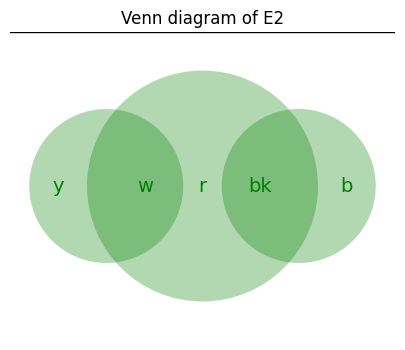

Example with E2 = [{'y', 'w'}, {'w', 'r', 'bk'}, {'bk', 'b'}]  : 
Subbasis: [{'y', 'w'}, {'r', 'bk', 'w'}, {'b', 'bk'}]
Basis: [{'y', 'w'}, {'r', 'bk', 'w'}, {'b', 'bk'}, {'w'}, set(), {'bk'}]
Topology:  [{'y', 'w'}, {'r', 'bk', 'w'}, {'b', 'bk'}, {'w'}, set(), {'bk'}, {'y', 'r', 'bk', 'w', 'b'}, {'y', 'w', 'r', 'bk'}, {'y', 'b', 'bk', 'w'}, {'y', 'bk', 'w'}, {'r', 'bk', 'w', 'b'}, {'b', 'w', 'bk'}, {'bk', 'w'}]
Dense sets:  [{'r', 'bk', 'w'}, {'y', 'r', 'bk', 'w', 'b'}, {'y', 'w', 'r', 'bk'}, {'y', 'b', 'bk', 'w'}, {'y', 'bk', 'w'}, {'r', 'bk', 'w', 'b'}, {'b', 'w', 'bk'}, {'bk', 'w'}]
Minimal dense set of E2 = {'bk', 'w'}


In [39]:
# Venn diagram of evidence set E2

fig, ax = plt.subplots(figsize=(8, 4))  # Create a figure and axis for the plot

ax.set_aspect('equal')  # Set equal aspect ratio

# Set the title and draw an underline under the title
title = ax.set_title("Venn diagram of E2")
ax.axhline(y=title.get_position()[1] - 0.2, color='black', linewidth=1)

# Draw blue circles with transparency
circle1 = Circle((0.5, 0), radius=0.4, fill=True, edgecolor='none', facecolor='green', alpha=0.3)
circle2 = Circle((1, 0), radius=0.6, fill=True, edgecolor='none', facecolor='green', alpha=0.3)
circle3 = Circle((1.5, 0), radius=0.4, fill=True, edgecolor='none', facecolor='green', alpha=0.3)

# Add the circles to the axis
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

# Add text labels
ax.text(0.25, 0, 'y', ha='center', va='center', color='green', fontsize=14)
ax.text(0.7, 0, 'w', ha='center', va='center', color='green', fontsize=14)
ax.text(1, 0, 'r', ha='center', va='center', color='green', fontsize=14)
ax.text(1.3, 0, 'bk', ha='center', va='center', color='green', fontsize=14)
ax.text(1.75, 0, 'b', ha='center', va='center', color='green', fontsize=14)

# Set the x-axis range to show the entire Venn diagram
ax.set_xlim(0, 2)
ax.set_ylim(-0.8, 0.8)

# Remove the x and y ticks, axis labels, and box around the plot
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Display the plot
plt.show()

# Topology of E2

topology2 = Topology(E2, S)

# Print object attributes
print("Example with E2 = [{'y', 'w'}, {'w', 'r', 'bk'}, {'bk', 'b'}]  : ")
topology2.print()

# Print minimal_dense_set function
minimal_dense_set_E2 = minimal_dense_set(E2)
print("Minimal dense set of E2 = " + str(minimal_dense_set_E2))

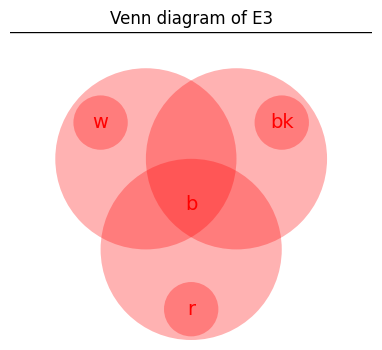

Example with E3 = [{'w', 'b'}, {'bk', 'b'}, {'b', 'r'}, {'w'}, {'bk'}, {'r'}]  : 
Subbasis: [{'b', 'w'}, {'b', 'bk'}, {'b', 'r'}, {'w'}, {'bk'}, {'r'}]
Basis: [{'b', 'w'}, {'b', 'bk'}, {'b', 'r'}, {'w'}, {'bk'}, {'r'}, {'b'}, set()]


Topology:  [{'b', 'w'}, {'b', 'bk'}, {'b', 'r'}, {'w'}, {'bk'}, {'r'}, {'b'}, set(), {'y', 'r', 'bk', 'w', 'b'}, {'b', 'bk', 'w'}, {'b', 'r', 'w'}, {'b', 'r', 'bk'}, {'bk', 'w'}, {'r', 'w'}, {'r', 'bk'}, {'bk', 'w', 'r', 'b'}, {'r', 'bk', 'w'}]
Dense sets:  [{'y', 'r', 'bk', 'w', 'b'}, {'bk', 'w', 'r', 'b'}]
Minimal dense set of E3 = {'bk', 'w', 'r', 'b'}


In [40]:
# Venn diagram of evidence set E3

fig, ax = plt.subplots(figsize=(8, 4))  # Create a figure and axis for the plot

ax.set_aspect('equal')  # Set equal aspect ratio

# Set the title and draw an underline under the title
title = ax.set_title("Venn diagram of E3")
ax.axhline(y=title.get_position()[1] - 0.3, color='black', linewidth=1)

# Draw blue circles with transparency
circle1 = Circle((-0.25, 0), radius=0.5, fill=True, edgecolor='none', facecolor='red', alpha=0.3)
circle2 = Circle((0.25, 0), radius=0.5, fill=True, edgecolor='none', facecolor='red', alpha=0.3)
circle3 = Circle((0, -0.5), radius=0.5, fill=True, edgecolor='none', facecolor='red', alpha=0.3)
circle4 = Circle((-0.5, 0.2), radius=0.15, fill=True, edgecolor='none', facecolor='red', alpha=0.3)
circle5 = Circle((0.5, 0.2), radius=0.15, fill=True, edgecolor='none', facecolor='red', alpha=0.3)
circle6 = Circle((0, -0.83), radius=0.15, fill=True, edgecolor='none', facecolor='red', alpha=0.3)

# Add the circles to the axis
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
ax.add_patch(circle5)
ax.add_patch(circle6)

# Add text labels
ax.text(-0.5, 0.2, 'w', ha='center', va='center', color='red', fontsize=14)
ax.text(0, -0.83, 'r', ha='center', va='center', color='red', fontsize=14)
ax.text(0.5, 0.2, 'bk', ha='center', va='center', color='red', fontsize=14)
ax.text(0, -0.25, 'b', ha='center', va='center', color='red', fontsize=14)

# Set the x-axis range to show the entire Venn diagram
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 0.7)

# Remove the x and y ticks, axis labels, and box around the plot
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Display the plot
plt.show()

# Topology of E3

topology3 = Topology(E3, S)

# Print object attributes
print("Example with E3 = [{'w', 'b'}, {'bk', 'b'}, {'b', 'r'}, {'w'}, {'bk'}, {'r'}]  : ")
topology3.print()

# Print minimal_dense_set function
minimal_dense_set_E3 = minimal_dense_set(E3)
print("Minimal dense set of E3 = " + str(minimal_dense_set_E3))

### Visualizing amount of dense sets in the topology

In the upcoming section, we will use the dense sets within the topology generated by $E$ to compute the degree of belief for propositions in various scenarios. Therefore, it is helpful to have a preliminary understanding of "how dense" our topology is. To achieve this, we propose the following visualization:

Given that the topology, excluding the empty set, contains $n$ elements, we will create a representation consisting of discs for each number from $2$ to $n$. The width of each disc will vary based on the number of elements within the topology that intersect with $2$, $3$, and so on, up to $n$ elements of the topology. Each element in the topology intersects with at least two sets: the total set and itself. Consequently, if the disc for the number 2 is wide, it indicates the presence of numerous disjoint elements within the topology. Conversely, if the disc for the number n is wide, it suggests the existence of many dense sets.

Below, you will find an illustration of what this plot looks like for $E1$, $E2$, and $E3$ from our previous example. For $E1$, all elements of the topology are dense; for $E2$, most elements are dense; and for $E3$, only a few elements are dense.

C:\Users\DPINTOP\AppData\Local\Temp\ipykernel_7548\2068526317.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((i, 0), radius=circle_radius, fill=True, edgecolor='none', color='blue', alpha = 0.5, linewidth=0.001)


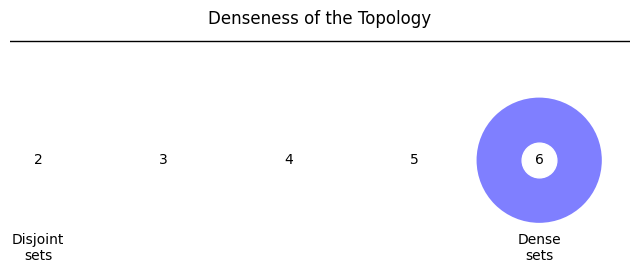

In [41]:
# Denseness plot for E1

topology = topology1.get_topology()
dense_sets = topology1.get_dense_sets()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figsize to your preference

# Set equal aspect ratio
ax.set_aspect('equal')

# Get non-empty elements of the topology
topology_without_empty = [element for element in topology if element != set()]

# Calculate the intersection counter for each element in the topology
intersection_counter = {}  # Dictionary to store the intersection counter for each element

for element in topology_without_empty:
    counter = 0
    
    for other_element in topology_without_empty:
        if element.intersection(other_element):
            counter += 1
    
    intersection_counter[get_key(element)] = counter

# Plot points and circles based on intersection counter
for i, element in enumerate(topology_without_empty, start = 1):
    keys_with_value_i = [key for key, value in intersection_counter.items() if value == i]
    
    if keys_with_value_i:
        circle_radius = len(keys_with_value_i) / len(topology_without_empty) * 0.5

    else:
        circle_radius = 0
    
    # Plot the circle with the adjusted transparency
    if i != 1:
        circle = Circle((i, 0), radius=circle_radius, fill=True, edgecolor='none', color='blue', alpha = 0.5, linewidth=0.001)
        ax.add_patch(circle)
    
        # Plot the disc centers
        ax.plot(i, 0, marker='o', markersize=25, color='white')
        ax.text(i, 0, str(i), ha='center', va='center', color='black')


    # Plot the "Disjoint sets" and "Dense sets" labels
    if i == 2:
        ax.text(i, -0.7, "Disjoint\nsets", ha='center', va='center', color='black')
    elif i == len(topology_without_empty):
        ax.text(i, -0.7, "Dense\nsets", ha='center', va='center', color='black')

# Remove the x and y ticks and set the title
ax.set_xticks([])
ax.set_yticks([])
title = ax.set_title("Denseness of the Topology")
title.set_position([.5, 1.1])  # Adjust the vertical position of the title

# Add an underline below the title
ax.axhline(y=title.get_position()[1] - 0.15, color='black', linewidth=1)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


C:\Users\DPINTOP\AppData\Local\Temp\ipykernel_7548\1642803230.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((i, 0), radius=circle_radius, fill=True, edgecolor='none', color='green', alpha = 0.5, linewidth=0.001)


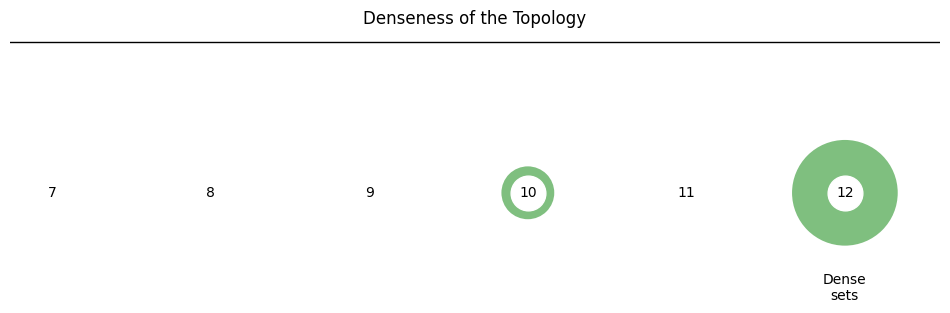

In [42]:
# Denseness plot for E2

topology = topology2.get_topology()
dense_sets = topology2.get_dense_sets()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize to your preference

# Set equal aspect ratio
ax.set_aspect('equal')

# Get non-empty elements of the topology
topology_without_empty = [element for element in topology if element != set()]

# Calculate the intersection counter for each element in the topology
intersection_counter = {}  # Dictionary to store the intersection counter for each element

for element in topology_without_empty:
    counter = 0
    
    for other_element in topology_without_empty:
        if element.intersection(other_element):
            counter += 1
    
    intersection_counter[get_key(element)] = counter

# Plot points and circles based on intersection counter
for i, element in enumerate(topology_without_empty, start = 1):
    keys_with_value_i = [key for key, value in intersection_counter.items() if value == i]
    
    if keys_with_value_i:
        circle_radius = len(keys_with_value_i) / len(topology_without_empty) * 0.5

    else:
        circle_radius = 0
    
    # Plot the circle with the adjusted transparency
    if i > 6 :
        circle = Circle((i, 0), radius=circle_radius, fill=True, edgecolor='none', color='green', alpha = 0.5, linewidth=0.001)
        ax.add_patch(circle)
    
         # Plot the disc centers
        ax.plot(i, 0, marker='o', markersize=25, color='white')
        ax.text(i, 0, str(i), ha='center', va='center', color='black')


    # Plot the "Disjoint sets" and "Dense sets" labels
    # if i == 2:
        # ax.text(i, -0.6, "Disjoint\nsets", ha='center', va='center', color='black')
    # elif i == len(topology_without_empty):
    if i == len(topology_without_empty):
        ax.text(i, -0.6, "Dense\nsets", ha='center', va='center', color='black')

# Remove the x and y ticks and set the title
ax.set_xticks([])
ax.set_yticks([])
title = ax.set_title("Denseness of the Topology")
title.set_position([.5, 1.1])  # Adjust the vertical position of the title

# Add an underline below the title
ax.axhline(y=title.get_position()[1] - 0.15, color='black', linewidth=1)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

C:\Users\DPINTOP\AppData\Local\Temp\ipykernel_7548\810352005.py:38: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((i, 0), radius=circle_radius, fill=True, edgecolor='none', color='red', alpha = 0.5, linewidth=0.001)


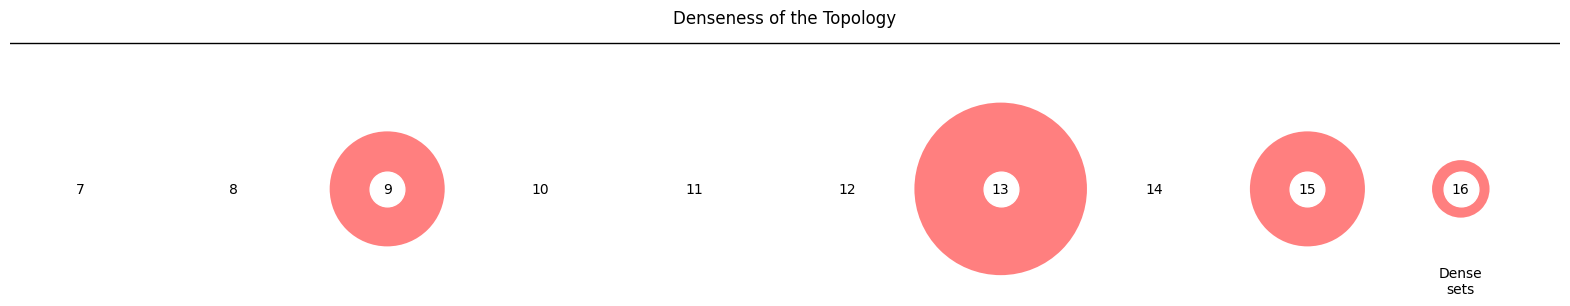

In [43]:
# Denseness plot for E3

topology = topology3.get_topology()
dense_sets = topology3.get_dense_sets()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust the figsize to your preference

# Set equal aspect ratio
ax.set_aspect('equal')

# Get non-empty elements of the topology
topology_without_empty = [element for element in topology if element != set()]

# Calculate the intersection counter for each element in the topology
intersection_counter = {}  # Dictionary to store the intersection counter for each element

for element in topology_without_empty:
    counter = 0
    
    for other_element in topology_without_empty:
        if element.intersection(other_element):
            counter += 1
    
    intersection_counter[get_key(element)] = counter

# Plot points and circles based on intersection counter
for i, element in enumerate(topology_without_empty, start = 1):
    keys_with_value_i = [key for key, value in intersection_counter.items() if value == i]
    
    if keys_with_value_i:
        circle_radius = len(keys_with_value_i) / len(topology_without_empty) * 1.5
    else:
        circle_radius = 0
    
    # Plot the circle with the adjusted transparency
    if i > 6:
        circle = Circle((i, 0), radius=circle_radius, fill=True, edgecolor='none', color='red', alpha = 0.5, linewidth=0.001)
        ax.add_patch(circle)
    
        # Plot the disc centers
        ax.plot(i, 0, marker='o', markersize=25, color='white')
        ax.text(i, 0, str(i), ha='center', va='center', color='black')


    # Plot the "Disjoint sets" and "Dense sets" labels
    # if i == 2:
        # ax.text(i, -0.6, "Disjoint\nsets", ha='center', va='center', color='black')
    # elif i == len(topology_without_empty):
    if i == len(topology_without_empty):
        ax.text(i, -0.6, "Dense\nsets", ha='center', va='center', color='black')

# Remove the x and y ticks and set the title
ax.set_xticks([])
ax.set_yticks([])
title = ax.set_title("Denseness of the Topology")
title.set_position([.5, 1.1])  # Adjust the vertical position of the title

# Add an underline below the title
ax.axhline(y=title.get_position()[1] - 0.15, color='black', linewidth=1)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


## 3 - Multi-Layer Belief Model class

In this section, we define a class that contains all the methods necessary to compute degrees of belief based on evidence using the multi-layer belief model.

As we discussed in the introduction, the essential inputs for these methods are a total set of states, for example:

$$ S = \{\text{white}, \text{yellow}, \text{red}, \text{blue}, \text{black}\} $$

and a set of uncertain pieces of evidence, for example:

$$ E = \{(\{\text{white},\text{black}\}, 0.66), (\{\text{white}, \text{black}, \text{red}, \text{yellow}\},0.70), (\{\text{black}, \text{blue}\},0.81)\}. $$ 

In addition, we've seen that two pieces of evidence contradict each other when the sets modeling them are disjoint.

Now, let's understand how the multi-layer belief model works and how to use the defined `Model class`. It's called a multi-layer model because it encompasses three logical levels:

<b>Layer 1: </b> The first step involves specifying our evidential demand to the model. This is achieved by defining what we call the *justification frame*. In the vocabulary of Topological Models of Evidence, given a set of evidence $E$ and the topology generated by it $\tau$, the non-empty elements of the topology are referred to as *arguments*. From these arguments, we can select some that possess specific topological properties, such as being *dense* in the topology. These special arguments are termed *justifications*, and the idea is to base the degree of belief computed by the model only on these arguments that meet the standars set by the user.

In the multi-layer belief model, defining the justification frame is a parameter that the user sets. Here are two options:

1 - J = dempster_shafer: If you choose this justification frame, you will consider all the arguments, which means every element of the topology (except for the empty set) is treated as a justification. This means you take into account all available information, including contradictory arguments.

2 - J = strong_denseness: If you choose this justification frame, you will only consider the dense arguments as justifications. This means you will use information that does not contradict any other available argument.

Depending on the context and whether you prioritize avoiding false negatives or false positives, you might choose one or the other. Additionally, although not covered in this notebook or the paper, intermediate justification frames can be defined.

<b>Layer 2: </b> The second step involves combining the degrees of certainty of the pieces of evidence to put them in context. In other words, if a piece of evidence like ${\text{white},\text{black}}$ has a certainty of 0.66, what does it mean when we also have evidence about ${\text{white},\text{black}, \text{red}, \text{yellow}}$ and ${\text{black},\text{blue}}$? To do this, we compute a function called the $\delta$-function.

This $\delta$-function is defined over the power set of $E$. This means that $\big\{\{\text{white},\text{black}\}, \{\text{black},\text{blue}\}\big\}$ will have a value between 0 and 1, as will every combination of pieces of evidence. The total sum of these values will be equal to one.

Although the $\delta$-function doesn't directly provide a degree of belief since our propositions are sets of elements (not sets of sets), it gives us an insight into where the highest values are concentrated. That's why we include a plot to visually identify how the values are distributed over the sets of pieces of evidence. This helps us set a second parameter in the following layer.

<b>Layer 3: </b> Finally, we need to merge the information from the previous layers. On one hand, we have the justifications; on the other hand, we have the combined values associated with sets of pieces of evidence. We want to associate these values with the justifications to use them to compute the degree of belief for a proposition. To this end, we define another parameter: the *allocation function*. This allocation function is an operation between sets that matches every set of pieces of evidence in the $\delta$-function domain to an element of the topology. This way, the value of the former is transferred to the latter.

While many allocation functions can be defined (you can check the general definition in the paper), here we consider three options:

1- set.intersection

2- set.union

3- minimal_dense_set

As previously mentioned, you can use the visualization of the $\delta$-function to see where the values are concentrated and choose the allocation function that will make the most effective use of them. For example, if values are concentrated in sets with two pieces of evidence and you have some contradictory pieces of evidence, using the intersection may transfer many values to the empty set, which is never a justification.

In conclusion, we are presenting a model that, with the justification frames and allocation functions defined, can be adapted to six different contexts. This can be achieved only using qualitative information—without modifying the degrees of certainty or setting thresholds. Additionally, if you want to return to the results of the approaches that inspired this model, you can make parameter selections as follows:

1- To obtain the results using Dempster's rule of combination, use the input: J = dempster_shafer and f = set.intersection.

2- To obtain the results using Topological Models of Evidence, use the input: J = strong_denseness and f = minimal_dense_set.

Check the examples at the end of this section to see how to use this implementation of the model, and feel free to share your conclusions with us!

<sub><b> Warning: </b> This code is not optimized. We compute and traverse the power set of the set of evidence. The intention of this implementation is to assist you in comprehending the model by experimenting with small examples.</sub>

In [44]:
class Model:
    
    """ This class defines an object Model containing all the information
        required to compute some degree of belief from a collection of uncertain pieces of evidence. 
        The user must provide as input the Justification frame (the criteria to consider an argument 
        good enough to justify degree of belief on those propositions implied by this argument); and 
        allocation fucntion (how we will interpret the sets of pieces of evience). For example, to 
        obtain the equivalent results to Demspter's rule of combination, the user must choose 
        'dempster_shafer' as Justification frame and 'set.intersection' as allocation function. """
    
   
    def __init__(self, S, E, J, f):
        """
        This is the constructor for Model.

        Args:
            S (set):          Space.
            E (dict):         Quantitative evidence.
            J (string):       Justification frame (dempster_shafer = dense and non-dense sets / strong_denseness =  dense sets of the topology). 
            f (function):     Allocation function (set.intersection/set.union/minimal_dense_set)

        Returns:
            None
        """
        
        self.space = S
        self.quantitative_evidence = E
        self.justification_frame = J
        self.allocation_function = f
        self.delta = None
        self.delta_tau = None
        self.delta_J = None
        

    
    
    def get_delta(self):
        """
        This method computes the delta function. For each combination of pieces of evidence,
        a corresponding delta value is computed. 
        
        Returns:
            dict (str, double) : For each combination of evidence, the delta value
        """
        
        # Avoid redundant computations
        if self.delta != None:
            return self.delta
        
        n = len(self.quantitative_evidence)
        pieces_of_evidence = [get_set(e) for e in self.quantitative_evidence.keys()]
        self.delta = {}
        
        for r in range(0,n+1):                               # For every size r of combination of pieces of evidence
            for combination in combinations(pieces_of_evidence, r):  # For all combinations of size r

                remaining_evidence = [e for e in pieces_of_evidence if e not in list(combination)]

                value = 1.0
                                
                for evidence in combination:  # For each piece of evidence in the combination
                    value *= self.quantitative_evidence[get_key(evidence)] # The value is multiplied by the new value
                                    
                for evidence in remaining_evidence: # For each piece of evidence not in the combination
                    value *= 1 - self.quantitative_evidence[get_key(evidence)] # The value is multiplied by 1 - the new value
                
                self.delta[str(list(combination))] = value   # We add the delta for this combination
        
        return self.delta
    
    def get_delta_tau(self):
        """
        This method computes the delta tau function. The allocation function is applied to each 
        argument of the delta function. The results constitutes the entries of the delta tau function.
        For each entry e, delta_tau(e) = sum(delta(a) if allocation(a) = e)
        
        Returns:
            dict(str, double) : For each combination of evidence, the delta value argument/ element of topology
        """

        # Avoid redundant computations
        if self.delta_tau != None:
            return self.delta_tau
        
        delta = self.get_delta().items()
        self.delta_tau = {}
        
        # Creation of new keys
        new_keys = []        
        for (combination,value) in delta: # Browsig entries of delta function
            argument = ast.literal_eval(combination) # Get the delta entry as a set

            if not argument:  # If delta entry is the empty set, new entry is S
                entry = self.space
            elif self.allocation_function == minimal_dense_set:
                entry = self.allocation_function(argument) # Compute allocation function on list
            else:
                entry = reduce(self.allocation_function, argument)  # Compute allocation function on list
            
            key = get_key(entry)


            if self.delta_tau.get(key):
                self.delta_tau[key] += value
            else:
                self.delta_tau[key] = value
            
            
            
        return self.delta_tau
    
    def get_justification_frame(self):
        """
        This method computes the justifications frame of the model.  
        
        Returns:
            list: list of sets
        """

        topology = Topology(self.quantitative_evidence, self.space)
        if self.justification_frame == 'dempster_shafer':
            justification_set = topology.get_topology()
            justification_set.remove(set())  # Remove the empty set from the topology
        elif self.justification_frame == 'strong_denseness':
            justification_set = topology.get_dense_sets()
        else:
            raise ValueError("Invalid value for J (Justification Frame). Must be 'dempster_shafer' or 'strong_denseness'.")
        
        return justification_set
    
    def get_normalization_factor(self):
        """
        This method computes the total sum of the frame of justifications.  
        
        Returns:
            denominator (double)
        """
        delta_tau = self.get_delta_tau()
        justification_set = self.get_justification_frame()
        
        denominator = sum(delta_tau[get_key(j)] for j in justification_set if get_key(j) in delta_tau) # Since delta_tau only contains elements with non-zero value, there may be j that are not in delta_tau
        
        return denominator

    
    def get_delta_J(self):
        """
        This method computes the deltaJ functions. 
        For each justification j in J, delta_J(j) = delta_tau(j) / sum(delta_tau(k) for k in J)
        
        Returns:
            dict (str, double) : For each combination of evidence, the delta value argument/ element of topology
        """

        # Avoid redundant computations
        if self.delta_J != None:
            return self.delta_J
        
    
        self.delta_J = {}
        delta_tau = self.get_delta_tau()
        """ topology = Topology(self.quantitative_evidence, self.space)
        if self.justification_frame == 'dempster_shafer':
            justification_set = topology.get_topology()
            justification_set.remove(set())  # Remove the empty set from the topology
        elif self.justification_frame == 'strong_denseness':
            justification_set = topology.get_dense_sets()
        else:
            raise ValueError("Invalid value for J (Justification Frame). Must be 'dempster_shafer' or 'strong_denseness'.")      
        
        
        denominator = sum(delta_tau[get_key(j)] for j in justification_set if get_key(j) in delta_tau) # Since delta_tau only contains elements with non-zero value, there may be j that are not in delta_tau
        print("Denominator: " + str(denominator)) """

        justification_set = self.get_justification_frame()
        denominator = self.get_normalization_factor()

        
        for justification in justification_set: # For all justification j
            key = get_key(justification)
            if key in delta_tau:                                    # If delta_tau(j) exists (has non-zero value)
                self.delta_J[key] = delta_tau[key] / denominator   #    Compute delta_j(j)
                
        testSum = sum(value for value in self.delta_J.values())
        print("Sum values: " + str(testSum))
        
        
        return self.delta_J
    

    def clear(self):
        """
        This method reinitializes the different tables of the objects.
        """

        self.delta = None
        self.delta_tau = None
        self.delta_J = None
    
    
    def degree_of_belief(self, proposition):
        """
        This method computes the degree of belief of a given proposition. 
        For a proposition p, degree_of_belief(p) = sum(delta_J(j) for j subset p)
        
        Returns:
            float : The degree of belief of p
        """
        
        delta_J = self.get_delta_J()
        
        return sum(delta_J[j] for j in delta_J if get_set(j).issubset(proposition))
        
    

### Examples of delta-function

Running the following code will display the values of the delta function for the previous sets of evidence. We have included a degree of certainty for each piece of evidence to make it work. It's important to note that while we choose a justification frame and an allocation function to run the model, computing the $\delta$-function is independent of these selections. This computation only depends on the evidence and its certainty degrees.

Scrolling down, you will also find a proposal for visualizing these values.

In the next section, you can explore a complete example where we go from uncertain evidence to the degree of belief we can get for different propositions in six possible scenarios.

In [45]:
# Input

# Total set of states
S = {'w', 'y', 'r', 'b', 'bk'}

# Non-contradictory set of evidence
E1 = {get_key({'r', 'y', 'w', 'bk'}):0.66,  get_key({'w', 'bk'}):0.70, get_key({'bk', 'b'}):0.81}

# Contradictory but dense set of evidence
E2 = {get_key({'y', 'w'}):0.65, get_key({'w', 'r', 'bk'}): 0.40, get_key({'bk', 'b'}):0.85} 

# Contradictory non-dense set of evidence
E3 = {get_key({'w', 'b'}):0.35, get_key({'bk', 'b'}):0.62, get_key({'b', 'r'}):0.47, get_key({'w'}):0.61, get_key({'bk'}):0.77, get_key({'r'}):0.83} 

# Justification frame
J = 'dempster_shafer'

# Allocation function
f = set.intersection

In [46]:
# delta-function for E1

model_1 = Model(S, E1, J, f)

# Print delta function
table = [[key, value] for key, value in model_1.get_delta().items()]

print("\nDelta for E1:\n")
print(tabulate(table, headers=['Set', 'Value'], tablefmt='orgtbl'))


Delta for E1:

| Set                                               |   Value |
|---------------------------------------------------+---------|
| []                                                | 0.01938 |
| [{'y', 'r', 'bk', 'w'}]                           | 0.03762 |
| [{'w', 'bk'}]                                     | 0.04522 |
| [{'b', 'bk'}]                                     | 0.08262 |
| [{'y', 'r', 'bk', 'w'}, {'w', 'bk'}]              | 0.08778 |
| [{'y', 'r', 'bk', 'w'}, {'b', 'bk'}]              | 0.16038 |
| [{'w', 'bk'}, {'b', 'bk'}]                        | 0.19278 |
| [{'y', 'r', 'bk', 'w'}, {'w', 'bk'}, {'b', 'bk'}] | 0.37422 |


In [47]:
# delta-function for E2

model_2 = Model(S, E2, J, f)

# Print delta function
table = [[key, value] for key, value in model_2.get_delta().items()]

print("\nDelta for E2:\n")
print(tabulate(table, headers=['Set', 'Value'], tablefmt='orgtbl'))


Delta for E2:

| Set                                         |   Value |
|---------------------------------------------+---------|
| []                                          |  0.0315 |
| [{'y', 'w'}]                                |  0.0585 |
| [{'r', 'bk', 'w'}]                          |  0.021  |
| [{'b', 'bk'}]                               |  0.1785 |
| [{'y', 'w'}, {'r', 'bk', 'w'}]              |  0.039  |
| [{'y', 'w'}, {'b', 'bk'}]                   |  0.3315 |
| [{'r', 'bk', 'w'}, {'b', 'bk'}]             |  0.119  |
| [{'y', 'w'}, {'r', 'bk', 'w'}, {'b', 'bk'}] |  0.221  |


In [48]:
# delta-function for E3

model_3 = Model(S, E3, J, f)

# Print delta function
table = [[key, value] for key, value in model_3.get_delta().items()]

print("\nDelta for E3:\n")
print(tabulate(table, headers=['Set', 'Value'], tablefmt='orgtbl'))


Delta for E3:

| Set                                                         |       Value |
|-------------------------------------------------------------+-------------|
| []                                                          | 0.00199625  |
| [{'b', 'w'}]                                                | 0.0010749   |
| [{'b', 'bk'}]                                               | 0.00325703  |
| [{'b', 'r'}]                                                | 0.00177026  |
| [{'w'}]                                                     | 0.00312233  |
| [{'bk'}]                                                    | 0.00668309  |
| [{'r'}]                                                     | 0.00974638  |
| [{'b', 'w'}, {'b', 'bk'}]                                   | 0.00175379  |
| [{'b', 'w'}, {'b', 'r'}]                                    | 0.000953215 |
| [{'b', 'w'}, {'w'}]                                         | 0.00168126  |
| [{'b', 'w'}, {'bk'}]                          

### Visual representation for delta-function

As mentioned earlier, the values of the $\delta$-function do not depend on the parameters set by the user (justification frame and allocation function). Therefore, it captures the certainty degrees of evidence after combination. Once the user sets the available parameters to compute the degree of belief based on this evidence, these values are distributed over the justification frame depending on the interpretation given by the user. However, users can anticipate whether an interpretation will dismiss high values or not by observing the results of the $\delta$-function. To help with this understanding, we propose the following visualization:

On the $y$-axis, you will see numbers from $0$ to the total number of pieces of evidence. The row for $0$ will have one box that corresponds to the empty set. The row for $1$ will have as many boxes as there are pieces of evidence available, corresponding to the singletons of the power set of $E$, and so on. Therefore, the row with $y = 2$ represents the sets of two pieces of evidence, the row with $y = 3$ represents the sets with three pieces of evidence, and so forth. These boxes have varying transparency depending on the $\delta$-value of the set they represent. The darker the box, the higher the $\delta$-value.

Observing this graph, you can assess whether it's likely that using the union would place high values in the total set (which represents the uncertainty of the model, increasing uncertainty with this interpretation) or whether using the intersection would place high values in the total set (which is never a justification). For example, if you have a lot of contradictions in your evidence set and the darker boxes are in the rows for two or more pieces of evidence, it might indicate that using the intersection could transfer many values to the empty set.

You can see how the plot for the $\delta$-functions of the previous examples would look like here.

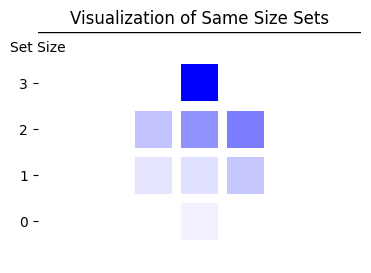

In [49]:
# Plot delta function for E1

#Define variable delta
delta = model_1.get_delta()

# Create a dictionary to store sets of the same size along with their delta values
same_size_sets = {}

# Populate the same_size_sets dictionary
for key, value in delta.items():
    length = len(ast.literal_eval(key))
    if length not in same_size_sets:
        same_size_sets[length] = (value,)
    else:
        same_size_sets[length] = same_size_sets[length] + (value,)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Set equal aspect ratio
ax.set_aspect('equal')

# List of y values for set plot dimenssions
y_ticks = [] 

# Denominator to normalize transparency of the plot
max_value = 0

for key,values in same_size_sets.items():
    for value in values:
        if value > max_value:
            max_value = value

# Plot squares for each group of sets
for key, values in same_size_sets.items():
    num_squares = len(values)
    y = int(key) 
    if num_squares % 2 == 0:
        x = 0 - ((num_squares / 2) + (num_squares / 2 - 1) * 0.2 + 0.1)
    else:
        x = 0 - (math.floor(num_squares / 2)  + 0.4)
    
    for value in values:
        alpha = value/max_value
        ax.add_patch(plt.Rectangle((x, y), 0.8, 0.8, color='blue', alpha=alpha, linewidth=0.001))
        x = x + 1
    y_ticks.append(y)

# Draw an horizontal line under the title
ax.axhline(y=title.get_position()[1] + max(y_ticks) + 0.5, color='black', linewidth=1)

# Adjust the y-axis range
ax.set_ylim(min(y_ticks) - 0.5, max(y_ticks) + 1.5)

# Adjust the x-axis range
ax.set_xlim(-max(y_ticks) - 0.5, max(y_ticks) + 0.5)

# Turn off the x-axis
ax.xaxis.set_visible(False)

# Set axis labels and possition and title
ax.set_ylabel('Set Size', rotation=0)
ax.yaxis.set_label_coords(0, 0.9)
ax.set_title('Visualization of Same Size Sets')

# Set y-axis tick labels
y_ticks_labels = list(same_size_sets.keys())
y_ticks = [val + 0.4 for val in y_ticks_labels]  # Adjusted tick labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_labels)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


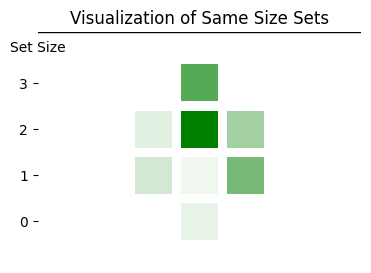

In [50]:
# Plot delta function for E2

#Define variable delta
delta = model_2.get_delta()

# Create a dictionary to store sets of the same size along with their delta values
same_size_sets = {}

# Populate the same_size_sets dictionary
for key, value in delta.items():
    length = len(ast.literal_eval(key))
    if length not in same_size_sets:
        same_size_sets[length] = (value,)
    else:
        same_size_sets[length] = same_size_sets[length] + (value,)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Set equal aspect ratio
ax.set_aspect('equal')

# List of y values for set plot dimenssions
y_ticks = []

# Denominator to normalize transparency of the plot
max_value = 0

for key,values in same_size_sets.items():
    for value in values:
        if value > max_value:
            max_value = value

# Plot squares for each group of sets
for key, values in same_size_sets.items():
    num_squares = len(values)
    y = int(key) 
    if num_squares % 2 == 0:
        x = 0 - ((num_squares / 2) + (num_squares / 2 - 1) * 0.2 + 0.1)
    else:
        x = 0 - (math.floor(num_squares / 2)  + 0.4)
    
    for value in values:
        alpha = value/max_value
        ax.add_patch(plt.Rectangle((x, y), 0.8, 0.8, color='green', alpha=alpha, linewidth=0.001))
        x = x + 1
    y_ticks.append(y)

# Draw an horizontal line under the title
ax.axhline(y=title.get_position()[1] + max(y_ticks) + 0.5, color='black', linewidth=1)

# Adjust the y-axis range
ax.set_ylim(min(y_ticks) - 0.5, max(y_ticks) + 1.5)

# Adjust the x-axis range
ax.set_xlim(-max(y_ticks) - 0.5, max(y_ticks) + 0.5)

# Turn off the x-axis
ax.xaxis.set_visible(False)

# Set axis labels and possition and title
ax.set_ylabel('Set Size', rotation=0)
ax.yaxis.set_label_coords(0, 0.9)
ax.set_title('Visualization of Same Size Sets')

# Set y-axis tick labels
y_ticks_labels = list(same_size_sets.keys())
y_ticks = [val + 0.4 for val in y_ticks_labels]  # Adjusted tick labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_labels)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

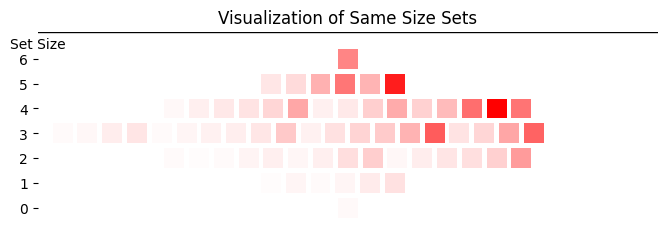

In [51]:
# Plot delta function for E3

#Define variable delta
delta = model_3.get_delta()

# Create a dictionary to store sets of the same size along with their delta values
same_size_sets = {}

# Populate the same_size_sets dictionary
for key, value in delta.items():
    length = len(ast.literal_eval(key))
    if length not in same_size_sets:
        same_size_sets[length] = (value,)
    else:
        same_size_sets[length] = same_size_sets[length] + (value,)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Set equal aspect ratio
ax.set_aspect('equal')

# List of y values for set plot dimenssions
y_ticks = [] 

# Denominator to normalize transparency of the plot
max_value = 0

for key,values in same_size_sets.items():
    for value in values:
        if value > max_value:
            max_value = value

# Plot squares for each group of sets
for key, values in same_size_sets.items():
    num_squares = len(values)    
    y = int(key) 
    if num_squares % 2 == 0:
        x = 0 - ((num_squares / 2) + (num_squares / 2 - 1) * 0.2 + 0.1)
    else:
        x = 0 - (math.floor(num_squares / 2)  + 0.4)

    for value in values:
        alpha = value/max_value
        ax.add_patch(plt.Rectangle((x, y), 0.8, 0.8, color='red', alpha=alpha, linewidth=0.001))
        x = x + 1
    y_ticks.append(y)

# Draw an horizontal line under the title
ax.axhline(y=title.get_position()[1] + max(y_ticks) + 0.5, color='black', linewidth=1)

# Adjust the y-axis range
ax.set_ylim(min(y_ticks) - 0.5, max(y_ticks) + 1.5)

# Adjust the x-axis range
ax.set_xlim(-max(y_ticks) - 6.5, max(y_ticks) + 6.5)

# Turn off the x-axis
ax.xaxis.set_visible(False)

# Set axis labels and possition and title
ax.set_ylabel('Set Size', rotation=0)
ax.yaxis.set_label_coords(0, 0.9)
ax.set_title('Visualization of Same Size Sets')

# Set y-axis tick labels
y_ticks_labels = list(same_size_sets.keys())
y_ticks = [val + 0.4 for val in y_ticks_labels]  # Adjusted tick labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_labels)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## 4 - Full example

In this section, we present the paper's running example in full detail. In this example, we consider the following situation:

Let $A$ be a fully autonomous car, and $B$ a driver-assist car. They both detect an object crossing the road in front of them. Due to the distance between the cars and the object, the desirable outcome would be to stop only if it is a static object or a pedestrian. Both cars collect the following pieces of evidence:

$(E1, 0.9)$: 'It is a dynamic object' with $90\%$ certainty.
$(E2, 0.75)$: 'It is a motorbike' with $75\%$ certainty.
$(E3, 0.45)$: 'It is a pedestrian' with $45\%$ certainty.

This situation translates to the following input:

In [52]:
 # Space set of states
S = {'dp', 'sp', 'dm', 'sm', 'do'} 

# Quantitative Evidence element subset of S
E = {get_key({'dp', 'dm', 'do'}): 0.9, get_key({'dm', 'sm'}): 0.75, get_key({'dp', 'sp'}): 0.45}      

The user can obtain six different models using the parameter options presented in the paper (which can be extended):

In [53]:
# Model 1: dempster_shafer + set.intersection

J_1 = 'dempster_shafer'      # Justification frame element subset of s
f_1 = set.intersection       # Allocation function

model_1 = Model(S, E, J_1, f_1)

# Model 2: dempster_shafer + set.union

J_2 = 'dempster_shafer'      # Justification frame element subset of s
f_2 = set.union              # Allocation function

model_2 = Model(S, E, J_2, f_2)

# Model 3: dempster_shafer + minimal_dense_set 

J_3 = 'dempster_shafer'      # Justification Frame element subset of s
f_3 = minimal_dense_set      # Allocation function

model_3 = Model(S, E, J_3, f_3)

# Model 4: strong_denseness + intersection

J_4 = 'strong_denseness'     # Justification Frame element subset of s
f_4 = set.intersection       # Allocation function

model_4 = Model(S, E, J_4, f_4)

# Model 5: strong_denseness + union

J_5 = 'strong_denseness'     # Justification Frame element subset of s
f_5 = set.union              # Allocation function

model_5 = Model(S, E, J_5, f_5)

# Model 6: strong_denseness + minimal dense set

J_6 = 'strong_denseness'     # Justification Frame element subset of s
f_6 = minimal_dense_set      # Allocation function

model_6 = Model(S, E, J_6, f_6)

Since we have a single set of evidence, all these models are based on the same topology and the same $\delta$-function. Below, you can see the plot illustrating the dense sets of the topology, as well as the table and plot showing the $\delta$-function.

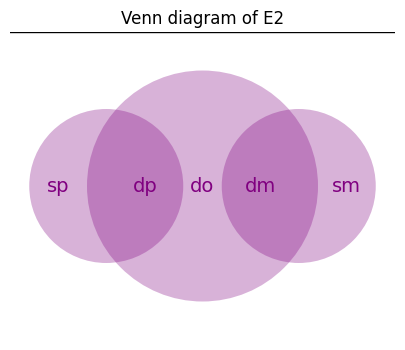

Example with E = [{'sp', 'dp'}, {'dp', 'do', 'dm'}, {'dm', 'sm'}]  : 
Subbasis: [{'dp', 'do', 'dm'}, {'sm', 'dm'}, {'dp', 'sp'}]
Basis: [{'dp', 'do', 'dm'}, {'sm', 'dm'}, {'dp', 'sp'}, {'dm'}, {'dp'}, set()]
Topology:  [{'dp', 'do', 'dm'}, {'sm', 'dm'}, {'dp', 'sp'}, {'dm'}, {'dp'}, set(), {'dp', 'do', 'sm', 'dm', 'sp'}, {'dp', 'do', 'sm', 'dm'}, {'dp', 'do', 'dm', 'sp'}, {'dp', 'sm', 'dm', 'sp'}, {'dp', 'sm', 'dm'}, {'dp', 'dm', 'sp'}, {'dp', 'dm'}]
Dense sets:  [{'dp', 'do', 'dm'}, {'dp', 'do', 'sm', 'dm', 'sp'}, {'dp', 'do', 'sm', 'dm'}, {'dp', 'do', 'dm', 'sp'}, {'dp', 'sm', 'dm', 'sp'}, {'dp', 'sm', 'dm'}, {'dp', 'dm', 'sp'}, {'dp', 'dm'}]


In [54]:
# Venn diagram of evidence set E

fig, ax = plt.subplots(figsize=(8, 4))  # Create a figure and axis for the plot

ax.set_aspect('equal')  # Set equal aspect ratio

# Set the title and draw an underline under the title
title = ax.set_title("Venn diagram of E2")
ax.axhline(y=title.get_position()[1] - 0.2, color='black', linewidth=1)

# Draw blue circles with transparency
circle1 = Circle((0.5, 0), radius=0.4, fill=True, edgecolor='none', facecolor='purple', alpha=0.3)
circle2 = Circle((1, 0), radius=0.6, fill=True, edgecolor='none', facecolor='purple', alpha=0.3)
circle3 = Circle((1.5, 0), radius=0.4, fill=True, edgecolor='none', facecolor='purple', alpha=0.3)

# Add the circles to the axis
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

# Add text labels
ax.text(0.25, 0, 'sp', ha='center', va='center', color='purple', fontsize=14)
ax.text(0.7, 0, 'dp', ha='center', va='center', color='purple', fontsize=14)
ax.text(1, 0, 'do', ha='center', va='center', color='purple', fontsize=14)
ax.text(1.3, 0, 'dm', ha='center', va='center', color='purple', fontsize=14)
ax.text(1.75, 0, 'sm', ha='center', va='center', color='purple', fontsize=14)

# Set the x-axis range to show the entire Venn diagram
ax.set_xlim(0, 2)
ax.set_ylim(-0.8, 0.8)

# Remove the x and y ticks, axis labels, and box around the plot
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Display the plot
plt.show()

# Topology of E

topology_class = Topology(E, S)

# Print object attributes
print("Example with E = [{'sp', 'dp'}, {'dp', 'do', 'dm'}, {'dm', 'sm'}]  : ")
topology_class.print()

C:\Users\DPINTOP\AppData\Local\Temp\ipykernel_7548\1653263588.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((i, 0), radius=circle_radius, fill=True, edgecolor='none', color='purple', alpha = 0.5, linewidth=0.001)


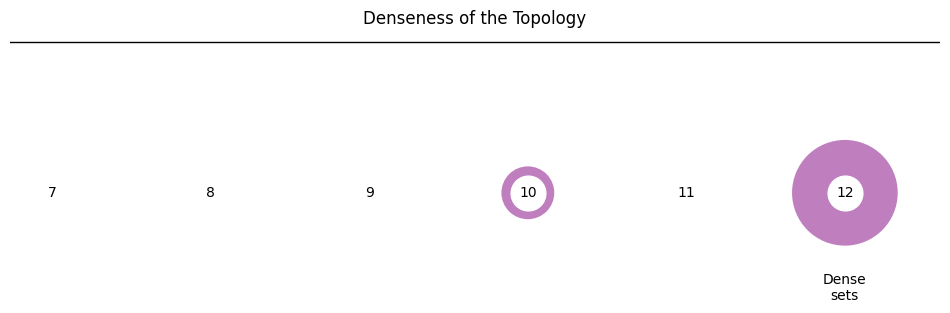

In [55]:
# Denseness plot for E

# Define the topology and the dense sets
topology = topology_class.get_topology()
dense_sets = topology_class.get_dense_sets()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize to your preference

# Set equal aspect ratio
ax.set_aspect('equal')

# Get non-empty elements of the topology
topology_without_empty = [element for element in topology if element != set()]

# Calculate the intersection counter for each element in the topology
intersection_counter = {}  # Dictionary to store the intersection counter for each element

for element in topology_without_empty:
    counter = 0
    
    for other_element in topology_without_empty:
        if element.intersection(other_element):
            counter += 1
    
    intersection_counter[get_key(element)] = counter

# Plot points and circles based on intersection counter
for i, element in enumerate(topology_without_empty, start = 1):
    keys_with_value_i = [key for key, value in intersection_counter.items() if value == i]
    
    if keys_with_value_i:
        circle_radius = len(keys_with_value_i) / len(topology_without_empty) * 0.5

    else:
        circle_radius = 0
    
    # Plot the circle with the adjusted transparency
    if i > 6 :
        circle = Circle((i, 0), radius=circle_radius, fill=True, edgecolor='none', color='purple', alpha = 0.5, linewidth=0.001)
        ax.add_patch(circle)
    
         # Plot the disc centers
        ax.plot(i, 0, marker='o', markersize=25, color='white')
        ax.text(i, 0, str(i), ha='center', va='center', color='black')


    # Plot the "Disjoint sets" and "Dense sets" labels
    # if i == 2:
        # ax.text(i, -0.6, "Disjoint\nsets", ha='center', va='center', color='black')
    # elif i == len(topology_without_empty):
    if i == len(topology_without_empty):
        ax.text(i, -0.6, "Dense\nsets", ha='center', va='center', color='black')

# Remove the x and y ticks and set the title
ax.set_xticks([])
ax.set_yticks([])
title = ax.set_title("Denseness of the Topology")
title.set_position([.5, 1.1])  # Adjust the vertical position of the title

# Add an underline below the title
ax.axhline(y=title.get_position()[1] - 0.15, color='black', linewidth=1)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

In [56]:
# delta table

#Define variable delta- model_2, model_3, model_4, model_5 and model_6 return the same delta-function
delta = model_1.get_delta()

# Print delta function 
table = [[key, value] for key, value in delta.items()] 

print("\nDelta:\n")
print(tabulate(table, headers=['Set', 'Value'], tablefmt='orgtbl'))


Delta:

| Set                                              |   Value |
|--------------------------------------------------+---------|
| []                                               | 0.01375 |
| [{'dp', 'do', 'dm'}]                             | 0.12375 |
| [{'sm', 'dm'}]                                   | 0.04125 |
| [{'dp', 'sp'}]                                   | 0.01125 |
| [{'dp', 'do', 'dm'}, {'sm', 'dm'}]               | 0.37125 |
| [{'dp', 'do', 'dm'}, {'dp', 'sp'}]               | 0.10125 |
| [{'sm', 'dm'}, {'dp', 'sp'}]                     | 0.03375 |
| [{'dp', 'do', 'dm'}, {'sm', 'dm'}, {'dp', 'sp'}] | 0.30375 |


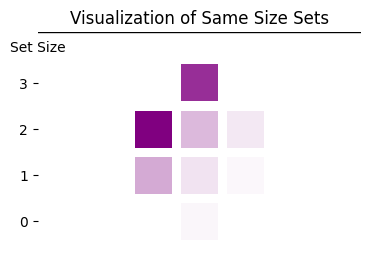

In [57]:
# Plot delta function for E

# Create a dictionary to store sets of the same size along with their delta values
same_size_sets = {}

# Populate the same_size_sets dictionary
for key, value in delta.items():
    length = len(ast.literal_eval(key))
    if length not in same_size_sets:
        same_size_sets[length] = (value,)
    else:
        same_size_sets[length] = same_size_sets[length] + (value,)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Set equal aspect ratio
ax.set_aspect('equal')

# List of y values for set plot dimenssions
y_ticks = []

# Denominator to normalize transparency of the plot
max_value = 0

for key,values in same_size_sets.items():
    for value in values:
        if value > max_value:
            max_value = value

# Plot squares for each group of sets
for key, values in same_size_sets.items():
    num_squares = len(values)
    y = int(key) 
    if num_squares % 2 == 0:
        x = 0 - ((num_squares / 2) + (num_squares / 2 - 1) * 0.2 + 0.1)
    else:
        x = 0 - (math.floor(num_squares / 2)  + 0.4)
    
    for value in values:
        alpha = value/max_value
        ax.add_patch(plt.Rectangle((x, y), 0.8, 0.8, color='purple', alpha=alpha, linewidth=0.001))
        x = x + 1
    y_ticks.append(y)

# Draw an horizontal line under the title
ax.axhline(y=title.get_position()[1] + max(y_ticks) + 0.5, color='black', linewidth=1)

# Adjust the y-axis range
ax.set_ylim(min(y_ticks) - 0.5, max(y_ticks) + 1.5)

# Adjust the x-axis range
ax.set_xlim(-max(y_ticks) - 0.5, max(y_ticks) + 0.5)

# Turn off the x-axis
ax.xaxis.set_visible(False)

# Set axis labels and possition and title
ax.set_ylabel('Set Size', rotation=0)
ax.yaxis.set_label_coords(0, 0.9)
ax.set_title('Visualization of Same Size Sets')

# Set y-axis tick labels
y_ticks_labels = list(same_size_sets.keys())
y_ticks = [val + 0.4 for val in y_ticks_labels]  # Adjusted tick labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_labels)

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


Finally, let's examine the intermediate functions of each model, that is, the functions that help us transfer the $\delta$ values to the topology first and to the set of justifications later. These functions are called the $\delta$-tau function and the $\delta$-J function.

### Intermediate functions of Model 1 (dempster_shafer + intersection)

In [65]:
# Print delta_tau function
table = [[key, value] for key, value in model_1.get_delta_tau().items()]

print("\nDelta tau for model 1:\n")
print(tabulate(table, headers=['Argument', 'Value'], tablefmt='orgtbl'))

# Print delta_J function
delta_J1 = model_1.get_delta_J()
table = [[key, value] for key, value in delta_J1.items()]

print("\nDelta J for model 1:\n")
print(tabulate(table, headers=['Justification', 'Value'], tablefmt='orgtbl'))


Delta tau for model 1:

| Argument                       |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.01375 |
| {'dm', 'do', 'dp'}             | 0.12375 |
| {'dm', 'sm'}                   | 0.04125 |
| {'dp', 'sp'}                   | 0.01125 |
| {'dm'}                         | 0.37125 |
| {'dp'}                         | 0.10125 |
| {}                             | 0.3375  |

Delta J for model 1:

| Justification                  |     Value |
|--------------------------------+-----------|
| {'dm', 'do', 'dp'}             | 0.186792  |
| {'dm', 'sm'}                   | 0.0622642 |
| {'dp', 'sp'}                   | 0.0169811 |
| {'dm'}                         | 0.560377  |
| {'dp'}                         | 0.15283   |
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.0207547 |


### Intermediate functions of Model 2 (dempster_shafer + union)

In [66]:
# Print delta_tau function
table = [[key, value] for key, value in model_2.get_delta_tau().items()]

print("\nDelta tau for model 2:\n")
print(tabulate(table, headers=['Argument', 'Value'], tablefmt='orgtbl'))

# Print delta_J function
delta_J2 = model_2.get_delta_J()
table = [[key, value] for key, value in delta_J2.items()]
print("\nDelta J for model 2:\n")
print(tabulate(table, headers=['Justification', 'Value'], tablefmt='orgtbl'))


Delta tau for model 2:

| Argument                       |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.3175  |
| {'dm', 'do', 'dp'}             | 0.12375 |
| {'dm', 'sm'}                   | 0.04125 |
| {'dp', 'sp'}                   | 0.01125 |
| {'dm', 'do', 'dp', 'sm'}       | 0.37125 |
| {'dm', 'do', 'dp', 'sp'}       | 0.10125 |
| {'dm', 'dp', 'sm', 'sp'}       | 0.03375 |

Delta J for model 2:

| Justification                  |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp'}             | 0.12375 |
| {'dm', 'sm'}                   | 0.04125 |
| {'dp', 'sp'}                   | 0.01125 |
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.3175  |
| {'dm', 'do', 'dp', 'sm'}       | 0.37125 |
| {'dm', 'do', 'dp', 'sp'}       | 0.10125 |
| {'dm', 'dp', 'sm', 'sp'}       | 0.03375 |


### Intermediate functions of Model 3 (dempster_shafer + minimal dense set)

In [67]:
# Print delta_tau function
table = [[key, value] for key, value in model_3.get_delta_tau().items()]

print("\nDelta tau for model 3:\n")
print(tabulate(table, headers=['Argument', 'Value'], tablefmt='orgtbl'))

# Print delta_J function
delta_J3 = model_3.get_delta_J()
table = [[key, value] for key, value in delta_J3.items()]

print("\nDelta J for model 3:\n")
print(tabulate(table, headers=['Justification', 'Value'], tablefmt='orgtbl'))


Delta tau for model 3:

| Argument                       |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.01375 |
| {'dm', 'do', 'dp'}             | 0.12375 |
| {'dm', 'sm'}                   | 0.04125 |
| {'dp', 'sp'}                   | 0.01125 |
| {'dm'}                         | 0.37125 |
| {'dp'}                         | 0.10125 |
| {'dm', 'dp', 'sm', 'sp'}       | 0.03375 |
| {'dm', 'dp'}                   | 0.30375 |

Delta J for model 3:

| Justification                  |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp'}             | 0.12375 |
| {'dm', 'sm'}                   | 0.04125 |
| {'dp', 'sp'}                   | 0.01125 |
| {'dm'}                         | 0.37125 |
| {'dp'}                         | 0.10125 |
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.01375 |
| {'dm', 'dp', 'sm', 'sp'}       | 0.03375 |
| {'dm', 'dp'}                   | 0.30375 |


### Intermediate functions of Model 4 (strong_denseness + intersection)

In [68]:
# Print delta_tau function
table = [[key, value] for key, value in model_4.get_delta_tau().items()]

print("\nDelta tau for model 4:\n")
print(tabulate(table, headers=['Argument', 'Value'], tablefmt='orgtbl'))

# Print delta_J function
delta_J4 = model_4.get_delta_J()
table = [[key, value] for key, value in delta_J4.items()]

print("\nDelta J for model 4:\n")
print(tabulate(table, headers=['Justification', 'Value'], tablefmt='orgtbl'))


Delta tau for model 4:

| Argument                       |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.01375 |
| {'dm', 'do', 'dp'}             | 0.12375 |
| {'dm', 'sm'}                   | 0.04125 |
| {'dp', 'sp'}                   | 0.01125 |
| {'dm'}                         | 0.37125 |
| {'dp'}                         | 0.10125 |
| {}                             | 0.3375  |

Delta J for model 4:

| Justification                  |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp'}             |     0.9 |
| {'dm', 'do', 'dp', 'sm', 'sp'} |     0.1 |


### Intermediate functions of Model 5 (strong_denseness + union)

In [69]:
# Print delta_tau function
table = [[key, value] for key, value in model_5.get_delta_tau().items()]

print("\nDelta tau for model 5:\n")
print(tabulate(table, headers=['Argument', 'Value'], tablefmt='orgtbl'))

# Print delta_J function
delta_J5 = model_5.get_delta_J()
table = [[key, value] for key, value in delta_J5.items()]

print("\nDelta J for model 5:\n")
print(tabulate(table, headers=['Justification', 'Value'], tablefmt='orgtbl'))


Delta tau for model 5:

| Argument                       |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.3175  |
| {'dm', 'do', 'dp'}             | 0.12375 |
| {'dm', 'sm'}                   | 0.04125 |
| {'dp', 'sp'}                   | 0.01125 |
| {'dm', 'do', 'dp', 'sm'}       | 0.37125 |
| {'dm', 'do', 'dp', 'sp'}       | 0.10125 |
| {'dm', 'dp', 'sm', 'sp'}       | 0.03375 |

Delta J for model 5:

| Justification                  |     Value |
|--------------------------------+-----------|
| {'dm', 'do', 'dp'}             | 0.130607  |
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.335092  |
| {'dm', 'do', 'dp', 'sm'}       | 0.391821  |
| {'dm', 'do', 'dp', 'sp'}       | 0.10686   |
| {'dm', 'dp', 'sm', 'sp'}       | 0.0356201 |


### Intermediate functions of Model 6 (strong_denseness + minimal dense set)

In [70]:
# Print delta_tau function
table = [[key, value] for key, value in model_6.get_delta_tau().items()]

print("\nDelta tau for model 6:\n")
print(tabulate(table, headers=['Argument', 'Value'], tablefmt='orgtbl'))

# Print delta_J function
delta_J6 = model_6.get_delta_J()
table = [[key, value] for key, value in delta_J6.items()]

print("\nDelta J for model 6:\n")
print(tabulate(table, headers=['Justification', 'Value'], tablefmt='orgtbl'))


Delta tau for model 6:

| Argument                       |   Value |
|--------------------------------+---------|
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.01375 |
| {'dm', 'do', 'dp'}             | 0.12375 |
| {'dm', 'sm'}                   | 0.04125 |
| {'dp', 'sp'}                   | 0.01125 |
| {'dm'}                         | 0.37125 |
| {'dp'}                         | 0.10125 |
| {'dm', 'dp', 'sm', 'sp'}       | 0.03375 |
| {'dm', 'dp'}                   | 0.30375 |

Delta J for model 6:

| Justification                  |     Value |
|--------------------------------+-----------|
| {'dm', 'do', 'dp'}             | 0.260526  |
| {'dm', 'do', 'dp', 'sm', 'sp'} | 0.0289474 |
| {'dm', 'dp', 'sm', 'sp'}       | 0.0710526 |
| {'dm', 'dp'}                   | 0.639474  |


### Degree of Belief according to Models 1 - 6

Now we can compare the degree of belief generated by each of these moldes for different propositions. 

In [64]:
# Define propositions
p1 = {'do', 'dm', 'dp'}
p2 = {'sp', 'dp'}
p3 = {'dm', 'sm'}
p4 = {'dm', 'dp'}

# Define the table degree of belief
table_belief = [
    ["(1)", "{dp,do,dm}", model_1.degree_of_belief(p1), model_2.degree_of_belief(p1), 
     model_3.degree_of_belief(p1), model_4.degree_of_belief(p1), model_5.degree_of_belief(p1), model_6.degree_of_belief(p1)],
    ["(2)", "{sp,dp}", model_1.degree_of_belief(p2), model_2.degree_of_belief(p2),
     model_3.degree_of_belief(p2), model_4.degree_of_belief(p2), model_5.degree_of_belief(p2), model_6.degree_of_belief(p2)],
    ["(3)", "{dm,sm}", model_1.degree_of_belief(p3), model_2.degree_of_belief(p3),
     model_3.degree_of_belief(p3), model_4.degree_of_belief(p3), model_5.degree_of_belief(p3), model_6.degree_of_belief(p3)],
    ["(4)", "{dp,dm}", model_1.degree_of_belief(p4), model_2.degree_of_belief(p4), 
     model_3.degree_of_belief(p4), model_4.degree_of_belief(p4), model_5.degree_of_belief(p4), model_6.degree_of_belief(p4)]
]

# Define the table belief headers
headers_belief = ["Proposition", "P", "Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"]  # Empty headers for the horizontal lines
horizontal_line = ["-"] * 8  # Horizontal line

# Compute uncertainty of the models
uncertainty_1 = delta_J1[get_key(S)]
uncertainty_2 = delta_J2[get_key(S)]
uncertainty_3 = delta_J3[get_key(S)]
uncertainty_4 = delta_J4[get_key(S)]
uncertainty_5 = delta_J5[get_key(S)]
uncertainty_6 = delta_J6[get_key(S)]

# Compute Normalization factor of the models

denominator_1 = model_1.get_normalization_factor()
denominator_2 = model_2.get_normalization_factor()
denominator_3 = model_3.get_normalization_factor()
denominator_4 = model_4.get_normalization_factor()
denominator_5 = model_5.get_normalization_factor()
denominator_6 = model_6.get_normalization_factor()

# Define the table of other metrics
table_metrics = [
    ["Uncertainty", "S", uncertainty_1, uncertainty_2,
      uncertainty_3, uncertainty_4, uncertainty_5, uncertainty_6],
    ["Normalization factor", "J", denominator_1, denominator_2,
     denominator_3, denominator_4, denominator_5, denominator_6]
]

headers_metrics = ["", "", "Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"]  # Empty headers for the horizontal lines
horizontal_line = ["-"] * 8  # Horizontal line

# Print the table
print("\nDegree of Belief:\n")
print(tabulate(table_belief, headers=headers_belief, tablefmt='orgtbl'))
print("\n(1): Dynamic object")
print("(2): Pedestrian")
print("(3): Motorbike")
print("(4): Dynamic person-motorbike\n")
print("\nOther metrics:\n")
print(tabulate(table_metrics, headers=headers_metrics, tablefmt='orgtbl'))


Degree of Belief:

| Proposition   | P          |   Model 1 |   Model 2 |   Model 3 |   Model 4 |   Model 5 |   Model 6 |
|---------------+------------+-----------+-----------+-----------+-----------+-----------+-----------|
| (1)           | {dp,do,dm} |  0.9      |   0.12375 |   0.9     |       0.9 |  0.130607 |  0.9      |
| (2)           | {sp,dp}    |  0.169811 |   0.01125 |   0.1125  |       0   |  0        |  0        |
| (3)           | {dm,sm}    |  0.622642 |   0.04125 |   0.4125  |       0   |  0        |  0        |
| (4)           | {dp,dm}    |  0.713208 |   0       |   0.77625 |       0   |  0        |  0.639474 |

(1): Dynamic object
(2): Pedestrian
(3): Motorbike
(4): Dynamic person-motorbike


Other metrics:

|                      |    |   Model 1 |   Model 2 |   Model 3 |   Model 4 |   Model 5 |   Model 6 |
|----------------------+----+-----------+-----------+-----------+-----------+-----------+-----------|
| Uncertainty          | S  | 0.0207547 |    0.3175 |   0.